In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST


"""UNCOMMENT BELOW IF YOU HAVE A CUDA-ENABLED NVIDIA GPU, otherwise uses CPU"""
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

"""USE THIS IF YOU HAVE A MAC WITH APPLE SILICON"""
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Hyperparameters
input_size = 784 # 28x28 pixels flattened (specific to MNIST dataset)
hidden_size = 128
num_classes = 10
num_epochs = 2
batch_size = 64
learning_rate = 0.001

# MNIST dataset
train_dataset = MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Neural network model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print('Training complete.')

# Testing the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')


Epoch [1/2], Step [100/938], Loss: 0.6166
Epoch [1/2], Step [200/938], Loss: 0.2407
Epoch [1/2], Step [300/938], Loss: 0.3414
Epoch [1/2], Step [400/938], Loss: 0.4121
Epoch [1/2], Step [500/938], Loss: 0.4291
Epoch [1/2], Step [600/938], Loss: 0.1207
Epoch [1/2], Step [700/938], Loss: 0.3190
Epoch [1/2], Step [800/938], Loss: 0.2109
Epoch [1/2], Step [900/938], Loss: 0.1272
Epoch [2/2], Step [100/938], Loss: 0.1921
Epoch [2/2], Step [200/938], Loss: 0.2596
Epoch [2/2], Step [300/938], Loss: 0.0689
Epoch [2/2], Step [400/938], Loss: 0.1237
Epoch [2/2], Step [500/938], Loss: 0.2018
Epoch [2/2], Step [600/938], Loss: 0.1548
Epoch [2/2], Step [700/938], Loss: 0.1146
Epoch [2/2], Step [800/938], Loss: 0.2894
Epoch [2/2], Step [900/938], Loss: 0.2004
Training complete.
Accuracy of the network on the 10000 test images: 96.17 %


Matplotlib is building the font cache; this may take a moment.


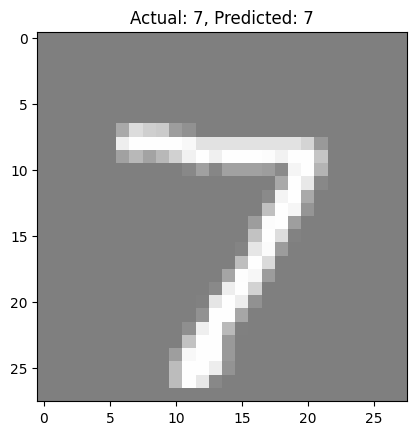

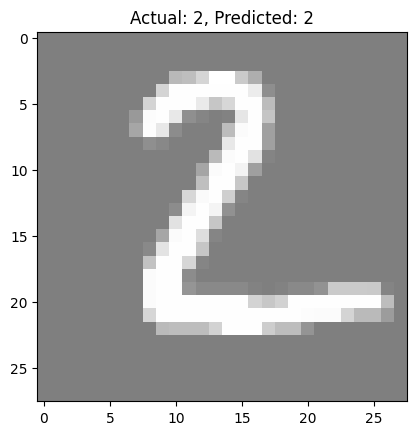

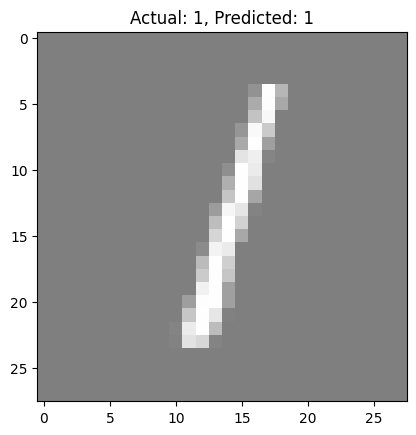

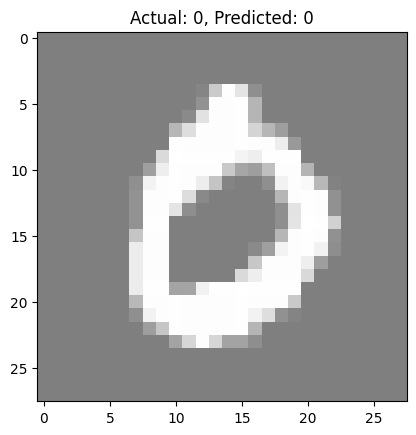

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Show images and labels
def imshow(img, label, pred):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f'Actual: {label}, Predicted: {pred}')
    plt.show()

# Get some random testing images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Show images and predictions
outputs = model(images.reshape(-1, 28*28).to(device))
_, predicted = torch.max(outputs, 1)

# Display the first few images, actual labels, and model's predictions (helps us see predicted-actual relationship)
for i in range(4):
    imshow(torchvision.utils.make_grid(images[i]), labels[i].item(), predicted[i].item())


In [9]:
import ipywidgets as widgets
from IPython.display import display

# Display an image and its prediction
def display_prediction(index):
    image, label = test_dataset[index]
    with torch.no_grad():
        pred = model(image.view(-1, 28*28).to(device)).argmax().item()
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Actual: {label}, Predicted: {pred}')
    plt.show()

# Slider widget (use the slider below)
slider = widgets.IntSlider(value=0, min=0, max=len(test_dataset)-1, step=1, description='Index:')
widgets.interactive(display_prediction, index=slider)


interactive(children=(IntSlider(value=0, description='Index:', max=9999), Output()), _dom_classes=('widget-int…